# Using ROBERTA to achieve 93% + accuracy in toxic comment classification

# Objective:
- Explore the exciting advantages in NLP that Google's ROBERTA model has over traditional NLP algorithms such as RNN and LSTM.
- Utilize TPUs to speed up lengthy calculations in tensorflow.
- Create albumentations in the training data to help the training data differentiate between "toxic" and "nontoxic" comments.
- Process the data to be utilized by ROBERTA
- Train the data once with the training data while using the validation dataset to make sure the model is able to generalize
- Train the data a second time on the validation dataset to help the model learn better on other languages outside of English (the validation and testing dataframes have multilingual comments).
- Submit predictions from the testing data into kaggle to see what Accuracy is achieved.

 Loading Libraries

In [1]:
from kaggle_datasets import KaggleDatasets
import random
import re
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

import numpy as np
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from transformers import TFAutoModel, AutoTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk import sent_tokenize
from albumentations.core.transforms_interface import DualTransform, BasicTransform

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import backend as K

import albumentations
import torch
from torch.utils.data import Dataset
import nltk

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Using TensorFlow backend.


 Loading the data from kaggle directories into Pandas Dataframes.

In [2]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

 Creating strategy to utilize tensorflow's TPUs to speed up calculations.

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


 These categories aren't seen in the validation or testing data. Because of this, I'm assuming that these would be classified as "Toxic" in the other data. To compensate for this, I am merging the values into simply the "Toxic" feature and dropping them to maintain the binary classification structure.

In [4]:
#merging values for binary classification
glue = ['severe_toxic','obscene','threat','insult','identity_hate']
for i in glue:
    train['toxic'] = np.where(train['toxic'] == 0, train[f'{i}'], train['toxic'])

train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

 Below, I'm doing a number of operations to try to make the training data more like the validation and testing data. Further, I'm also implementing albumentations into the training data in an effort to help the model better differentiate between toxic and nontoxic text. 

In [5]:
class NLPTransform(BasicTransform):
    """ Transform for nlp task."""
    LANGS = {
        'en': 'english',
        'it': 'italian', 
        'fr': 'french', 
        'es': 'spanish',
        'tr': 'turkish', 
        'ru': 'russian',
        'pt': 'portuguese'
    }

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, self.LANGS.get(lang, 'english'))

In [6]:
class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang

In [7]:
class ExcludeDuplicateSentencesTransform(NLPTransform):
    """ Exclude equal sentences """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeDuplicateSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = []
        for sentence in self.get_sentences(text, lang):
            sentence = sentence.strip()
            if sentence not in sentences:
                sentences.append(sentence)
        return ' '.join(sentences), lang

In [8]:
class ExcludeNumbersTransform(NLPTransform):
    """ exclude any numbers """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeNumbersTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

In [9]:
class ExcludeHashtagsTransform(NLPTransform):
    """ Exclude any hashtags with # """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeHashtagsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'#[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

In [10]:
class ExcludeUsersMentionedTransform(NLPTransform):
    """ Exclude @users """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUsersMentionedTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'@[\S]+\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

In [11]:
class ExcludeUrlsTransform(NLPTransform):
    """ Exclude urls """
    def __init__(self, always_apply=False, p=0.5):
        super(ExcludeUrlsTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        text = re.sub(r'https?\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text, lang

In [12]:
class SwapWordsTransform(NLPTransform):
    """ Swap words next to each other """
    def __init__(self, swap_distance=1, swap_probability=0.1, always_apply=False, p=0.5):
        """  
        swap_distance - distance for swapping words
        swap_probability - probability of swapping for one word
        """
        super(SwapWordsTransform, self).__init__(always_apply, p)
        self.swap_distance = swap_distance
        self.swap_probability = swap_probability
        self.swap_range_list = list(range(1, swap_distance+1))

    def apply(self, data, **params):
        text, lang = data
        words = text.split()
        words_count = len(words)
        if words_count <= 1:
            return text, lang

        new_words = {}
        for i in range(words_count):
            if random.random() > self.swap_probability:
                new_words[i] = words[i]
                continue
    
            if i < self.swap_distance:
                new_words[i] = words[i]
                continue
    
            swap_idx = i - random.choice(self.swap_range_list)
            new_words[i] = new_words[swap_idx]
            new_words[swap_idx] = words[i]

        return ' '.join([v for k, v in sorted(new_words.items(), key=lambda x: x[0])]), lang

In [13]:
class CutOutWordsTransform(NLPTransform):
    """ Remove random words """
    def __init__(self, cutout_probability=0.05, always_apply=False, p=0.5):
        super(CutOutWordsTransform, self).__init__(always_apply, p)
        self.cutout_probability = cutout_probability

    def apply(self, data, **params):
        text, lang = data
        words = text.split()
        words_count = len(words)
        if words_count <= 1:
            return text, lang
        
        new_words = []
        for i in range(words_count):
            if random.random() < self.cutout_probability:
                continue
            new_words.append(words[i])

        if len(new_words) == 0:
            return words[random.randint(0, words_count-1)], lang

        return ' '.join(new_words), lang

In [14]:
class AddNonToxicSentencesTransform(NLPTransform):
    """ Add random non toxic statement """
    def __init__(self, non_toxic_sentences, sentence_range=(1, 3), always_apply=False, p=0.5):
        super(AddNonToxicSentencesTransform, self).__init__(always_apply, p)
        self.sentence_range = sentence_range
        self.non_toxic_sentences = non_toxic_sentences

    def apply(self, data, **params):
        text, lang = data

        sentences = self.get_sentences(text, lang)
        for i in range(random.randint(*self.sentence_range)):
            sentences.append(random.choice(self.non_toxic_sentences))
        
        random.shuffle(sentences)
        return ' '.join(sentences), lang

In [15]:
def get_train_transforms():
    return albumentations.Compose([
        ExcludeDuplicateSentencesTransform(p=0.9),  # here not p=1.0 because your nets should get some difficulties
        albumentations.OneOf([
            AddNonToxicSentencesTransform(non_toxic_sentences=list(non_toxic_sentences), p=0.8, sentence_range=(1,3)),
            ShuffleSentencesTransform(p=0.8),
        ]),
        ExcludeNumbersTransform(p=0.8),
        ExcludeHashtagsTransform(p=0.5),
        ExcludeUsersMentionedTransform(p=0.9),
        ExcludeUrlsTransform(p=0.9),
        CutOutWordsTransform(p=0.1),
        SwapWordsTransform(p=0.1),
    ])

In [16]:
class DatasetRetriever(Dataset):

    def __init__(self, df, train_transforms=None):
        self.comment_texts = df['comment_text'].values
        self.langs = df['lang'].values
        self.train_transforms = train_transforms

    def __len__(self):
        return self.comment_texts.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]
        lang = self.langs[idx]
        if self.train_transforms:
            text, _ = self.train_transforms(data=(text, lang))['data']
        return text

In [17]:
nlp_transform = NLPTransform()

df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv', nrows= 1000)
df = df[df.toxic == 0]
df['lang'] = 'en'
non_toxic_sentences = set()
for comment_text in tqdm(df['comment_text'], total=df.shape[0]):
    non_toxic_sentences.update(nlp_transform.get_sentences(comment_text), 'en')

transform = AddNonToxicSentencesTransform(non_toxic_sentences=list(non_toxic_sentences), p=1.0, sentence_range=(1,2))

100%|██████████| 895/895 [00:00<00:00, 3180.00it/s]


In [18]:
dataset = DatasetRetriever(df, train_transforms=get_train_transforms())
for albumentation_text in tqdm(dataset, total=len(dataset)):
    pass

100%|██████████| 895/895 [00:00<00:00, 1002.84it/s]


In [19]:
df.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [20]:
frames = [train, df]
train = pd.concat(frames)

In [21]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

2321

Defining a helper function for AUC

In [22]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

 Splitting the data in an 80-20 split.

In [23]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

 Calling and defining attributes for the neural network and the final encoding.

In [24]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
MODEL = 'jplu/tf-xlm-roberta-large'

In [25]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

 Creating an encoding function to make the data usable in ROBERTA.

In [26]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

 Encoding the data.

In [27]:
x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

 Making skeleton model.

In [28]:
def build_model(transformer, loss = 'binary_crossentropy',  max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    
    model.compile(Adam(lr=1e-6), loss= loss, metrics=['accuracy'])
    
    return model

Utilizing a loss function designed by researches from Facebook to be optimal for binary classification tasks.

In [29]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

Final transform for utilization of data into ROBERTA.

In [30]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

Loading ROBERTA to utilize TPUs.

In [31]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer,loss=focal_loss(gamma=1.5), max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 5s, sys: 39.7 s, total: 2min 44s
Wall time: 2min 41s


Using learning rate scheduler for dynamic learning rate.

In [32]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

Training the data on the training data.

In [33]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)


n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch= n_steps,
    validation_data=valid_dataset,
    callbacks=[lr_schedule],
    epochs= 5
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


1753/1753 [==============================] - 775s 442ms/step - accuracy: 0.9033 - loss: 0.0353 - val_accuracy: 0.8530 - val_loss: 0.0486 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/5
1753/1753 [==============================] - 741s 423ms/step - accuracy: 0.9478 - loss: 0.0147 - val_accuracy: 0.8591 - val_loss: 0.0456 - lr: 3.1429e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714285e-06.
Epoch 3/5
1753/1753 [==============================] - 741s 423ms/step - accuracy: 0.9550 - loss: 0.0123 - val_accuracy: 0.8584 - val_loss: 0.0507 - lr: 5.2857e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 7.4285714285714275e-06.
Epoch 4/5
1753/1753 [==============================] - 742s 423ms/step - accuracy: 0.9562 - loss: 0.0117 - val_accuracy: 0.8638 - val_loss: 0.0391 - lr: 7.4286e-06

Epoch 00005: LearningRateScheduler reducing learning rate to 9.571428571428572e-06.
Epoch 5/5
175

Training the data on the validation data

In [34]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    callbacks=[lr_schedule],
    epochs= 5
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/5
62/62 [==============================] - 25s 411ms/step - accuracy: 0.8681 - loss: 0.0342 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/5
62/62 [==============================] - 26s 411ms/step - accuracy: 0.8830 - loss: 0.0272 - lr: 3.1429e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714285e-06.
Epoch 3/5
62/62 [==============================] - 25s 408ms/step - accuracy: 0.9018 - loss: 0.0243 - lr: 5.2857e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 7.4285714285714275e-06.
Epoch 4/5
62/62 [==============================] - 25s 408ms/step - accuracy: 0.9201 - loss: 0.0201 - lr: 7.4286e-06

Epoch 00005: LearningRateScheduler reducing learning rate to 9.571428571428572e-06.
Epoch 5/5
62/62 [==============================] - 25s 409ms/step - accuracy: 0.9315 - loss: 0.0171 - lr: 9.5714e-06


 Creating predictions and writing them to CSV to test final accuracy.

In [35]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 63s 126ms/step


# Result:

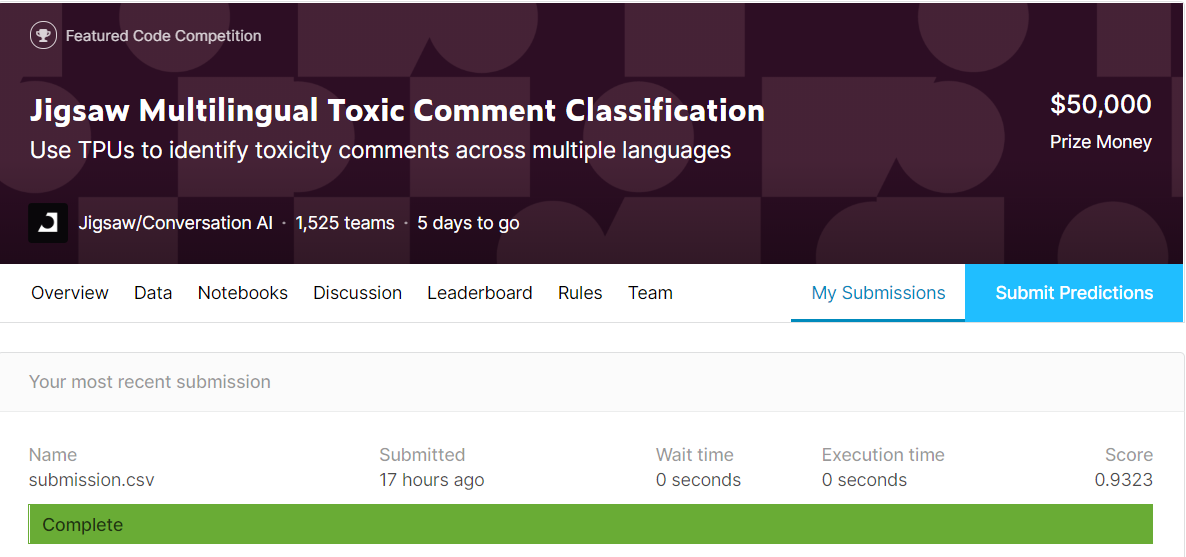

# Conclusion:

I entered this kaggle competition as a way to explore new extensions of machine learning into NLP. I was pleasantly surprised at the high level of accuracy that can be achieved utilizing transfer learning from Google's ROBERTA and applying the concept of albumentations from computer vision to NLP. I am excited to see where this field goes moving forward and hope to be able to contribute to its evolution.